In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import pandas as pd
from collections import Counter

In [2]:
from sklearn.neighbors import KNeighborsClassifier

In [3]:
nba_players = pd.read_csv('./NBA_clean.csv', index_col=0)
nba_players = nba_players.sample(frac=1) #shuffle 100% of rows
nba_players = nba_players.reset_index(drop=True)
"""
nba_players = nba_players.drop(['MIN', 'Age', 'Weight', 'BMI', 'OREB', 'DREB', 'FTM',  'FTA', 'FT%', 'TOV', 'PF', 'EFF', 'AST/TOV', 'STL/TOV', 'FGM', 'FGA', '3PM', '3PA'], axis=1)
for stat in nba_players:
    print(stat)
nba_players = nba_players.reset_index(drop=True)
#nba_players
"""

"\nnba_players = nba_players.drop(['MIN', 'Age', 'Weight', 'BMI', 'OREB', 'DREB', 'FTM',  'FTA', 'FT%', 'TOV', 'PF', 'EFF', 'AST/TOV', 'STL/TOV', 'FGM', 'FGA', '3PM', '3PA'], axis=1)\nfor stat in nba_players:\n    print(stat)\nnba_players = nba_players.reset_index(drop=True)\n#nba_players\n"

In [4]:
def normalize(nba_players):
    nbamean = np.mean(nba_players.loc[:, nba_players.columns != 'Pos'], axis = 0)
    nba_players = nba_players - nbamean
    nbastd = np.std(nba_players.loc[:, nba_players.columns != 'Pos'], axis = 0)
    nba_players = nba_players / nbastd
    #for stat in nba_players.loc[:, nba_players.columns != 'Pos']:
    #    nba_players[stat] = nba_players[stat] - np.mean(nba_players[stat])
    #for stat in nba_players.loc[:, nba_players.columns != 'Pos']:
    #    nba_players[stat] = nba_players[stat]/np.std(nba_players[stat])
    return nba_players, nbamean, nbastd

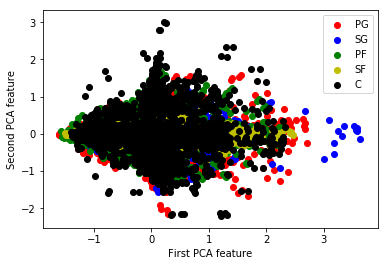

In [5]:
normalized_data,_,_ = normalize(nba_players.loc[:, nba_players.columns != 'Pos'])

f = normalized_data.loc[:, normalized_data.columns != 'Pos']
U,S,Vh = np.linalg.svd(f.T, full_matrices=True)

Uhat = U[:,0][:,None]
PC1 = np.matmul(Uhat, np.matmul(Uhat.T, f.T)).T
Uhat = U[:,1][:,None]
PC2 = np.matmul(Uhat, np.matmul(Uhat.T, f.T)).T

idx1 = np.where(nba_players['Pos'] == 'PG')[0]
idx2 = np.where(nba_players['Pos'] == 'SG')[0]
idx3 = np.where(nba_players['Pos'] == 'PF')[0]
idx4 = np.where(nba_players['Pos'] == 'SF')[0]
idx5 = np.where(nba_players['Pos'] == 'C')[0]

plt.scatter(PC1[idx1], PC2[idx1], c='r')
plt.scatter(PC1[idx2], PC2[idx2], c='b')
plt.scatter(PC1[idx3], PC2[idx3], c='g')
plt.scatter(PC1[idx4], PC2[idx4], c='y')
plt.scatter(PC1[idx5], PC2[idx5], c='k')
plt.legend(['PG', 'SG', 'PF', 'SF', 'C'])
plt.xlabel('First PCA feature')
plt.ylabel('Second PCA feature')
plt.show()


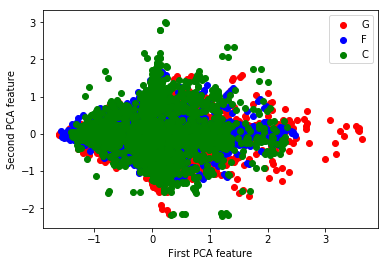

In [6]:
labels = nba_players.loc[:, 'Pos']
genpos = []
for a in labels:
    genpos.append(a[-1])
generalized_nba_players = nba_players.loc[:, nba_players.columns != 'Pos']
generalized_nba_players['Pos'] = genpos

normalized_data,_,_ = normalize(generalized_nba_players.loc[:, generalized_nba_players.columns != 'Pos'])

f = normalized_data.loc[:, normalized_data.columns != 'Pos']
U,S,Vh = np.linalg.svd(f.T, full_matrices=True)

Uhat = U[:,0][:,None]
PC1 = np.matmul(Uhat, np.matmul(Uhat.T, f.T)).T
Uhat = U[:,1][:,None]
PC2 = np.matmul(Uhat, np.matmul(Uhat.T, f.T)).T

idx1 = np.where(generalized_nba_players['Pos'] == 'G')[0]
idx2 = np.where(generalized_nba_players['Pos'] == 'F')[0]
idx3 = np.where(generalized_nba_players['Pos'] == 'C')[0]

plt.scatter(PC1[idx1], PC2[idx1], c='r')
plt.scatter(PC1[idx2], PC2[idx2], c='b')
plt.scatter(PC1[idx3], PC2[idx3], c='g')
plt.legend(['G', 'F', 'C'])
plt.xlabel('First PCA feature')
plt.ylabel('Second PCA feature')
plt.show()

In [7]:
validation_data  = nba_players.loc[360:421, nba_players.columns != 'Pos']
validation_labels = nba_players.loc[360:421, 'Pos']

gen_validation_data  = generalized_nba_players.loc[360:421, generalized_nba_players.columns != 'Pos']
gen_validation_labels = generalized_nba_players.loc[360:421, 'Pos']

In [8]:
splits = [0, 60 - 1, 120 - 1, 180 - 1, 240 - 1, 300 - 1, 360 - 1]

def cross_validation(nba_players, KNN):
    p = []
    for i in range(len(splits) - 1):
        #print(i)
        s1 = training_data = nba_players.loc[0:splits[i]-1, nba_players.columns != 'Pos']
        s2 = training_data = nba_players.loc[splits[i+1]+1:359, nba_players.columns != 'Pos']
        l1 = training_data = nba_players.loc[0:splits[i]-1, 'Pos']
        l2 = training_data = nba_players.loc[splits[i+1]+1:359,  'Pos']
        training_data = pd.concat([s1, s2])
        training_labels = pd.concat([l1, l2])
        testing_data = nba_players.loc[splits[i]:splits[i+1], nba_players.columns != 'Pos']
        testing_labels = nba_players.loc[splits[i]:splits[i+1], 'Pos']
        training_data = training_data.reset_index(drop=True)
        testing_data = testing_data.reset_index(drop=True)

        #testing_data = normalize(testing_data)
        training_data, tmean, tstd = normalize(training_data)
        U,S,Vh = np.linalg.svd(training_data.T, full_matrices=True)
        totalerr = np.linalg.norm(S,2)**2
        currenterr = 0
        idx = 0
        while currenterr < 0.95*totalerr:
            currenterr+=S[idx]**2
            idx+=1
        Uhat = U[:,:idx]
        training_data = np.matmul(Uhat, np.matmul(Uhat.T, training_data.T)).T
        testing_data = (testing_data - tmean)/tstd
        testing_data = np.matmul(Uhat, np.matmul(Uhat.T, testing_data.T)).T

        KNN.fit(training_data, training_labels)
        acc = KNN.score(testing_data, testing_labels)
        p.append(acc)
    return np.mean(p)
#KNN3 = KNeighborsClassifier(n_neighbors=3)
#KNN3.fit(nba_players.loc[0:359, nba_players.columns != 'Pos'], nba_players.loc[0:359, 'Pos'])

In [9]:
klist = [4,5,6,7,8,9,10,11,12]
perf = []
for k in klist:
    KNN = KNeighborsClassifier(n_neighbors=k)
    perf.append(cross_validation(nba_players, KNN))
print(perf)

[0.6361111111111111, 0.633287795992714, 0.625136612021858, 0.6278233151183971, 0.6359744990892532, 0.6304189435336977, 0.6249544626593807, 0.638752276867031, 0.6304189435336977]


In [10]:
#validate
def validateKNN(nba_players, validation_data, validation_labels):
    print(klist[np.argmax(perf)])
    KNN = KNeighborsClassifier(n_neighbors=klist[np.argmin(perf)])
    training_data = nba_players.loc[0:359, nba_players.columns != 'Pos']
    training_labels = nba_players.loc[0:359, 'Pos']
    training_data = training_data.reset_index(drop=True)
    training_data, tmean, tstd = normalize(training_data)
    U,S,Vh = np.linalg.svd(training_data.T, full_matrices=True)
    totalerr = np.linalg.norm(S,2)**2
    currenterr = 0
    idx = 0
    while currenterr < 0.95*totalerr:
        currenterr+=S[idx]**2
        idx+=1
    Uhat = U[:,:idx]
    training_data = np.matmul(Uhat, np.matmul(Uhat.T, training_data.T)).T

    KNN.fit(training_data, training_labels)
    #validation_data = normalize(validation_data)
    validation_data = (validation_data - tmean)/tstd
    validation_data = np.matmul(Uhat, np.matmul(Uhat.T, validation_data.T)).T
    acc = KNN.score(validation_data, validation_labels)
    print(acc)

In [11]:
validateKNN(nba_players, validation_data, validation_labels)

11
0.5483870967741935


In [12]:
klist = [4,5,6,7,8,9,10,11,12]
perf = []
for k in klist:
    KNN = KNeighborsClassifier(n_neighbors=k)
    perf.append(cross_validation(generalized_nba_players, KNN))
print(perf)

[0.7892987249544626, 0.7755009107468123, 0.7837431693989071, 0.8056921675774135, 0.7946265938069216, 0.7973132969034608, 0.8029143897996356, 0.8110655737704917, 0.8000910746812386]


In [13]:
validateKNN(generalized_nba_players, gen_validation_data, gen_validation_labels)

11
0.7741935483870968
